In [1]:
! pip install bayesian-optimization

In [2]:
# 导入基本的库，每个项目的必备
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
import warnings
#将warning过滤掉
warnings.filterwarnings('ignore')
# 设置matplotlib的模式
%matplotlib inline
# 设置matplot的样式
matplotlib.style.use('ggplot')
#导入成功
print('导入成功！')

导入成功！


In [3]:
pd.set_option('max_columns',100)

In [4]:
# 通过pandas读取.csv文件，并展示头几个样本。
data_df = pd.read_csv('train_subset.csv')
#展示前五个样本
data_df.head(10)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157
5,1.000072e+19,0,14102100,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,05241af0,8a4875bd,1,0,16920,320,50,1899,0,431,100077,117
6,1.000072e+19,0,14102100,1005,0,8fda644b,25d4cfcd,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,b264c159,be6db1d7,1,0,20362,320,50,2333,0,39,-1,157
7,1.000092e+19,0,14102100,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278,be74e6fe,1,0,20632,320,50,2374,3,39,-1,23
8,1.000095e+19,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,37e8da74,5db079b5,1,2,15707,320,50,1722,0,35,-1,79
9,1.000126e+19,0,14102100,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6,0,0,21689,320,50,2496,3,167,100191,23


问题1（TODO）： 在上面的数据中有一个特征叫作hour, 是时间的特征，但这个值有些看不懂... 这部分需要通过pandas来做处理。把这个数转换成具体时间的格式。请把这个特征格式化成%y%m%d%H形式。格式化完之后请覆盖掉原来的特征。提示： 使用 pd.to_datetime函数，然后指定需要格式化的特征和格式化的样式。


In [5]:
# TODO 把hour特征格式化成 '%y%m%d%H'形式。
#将hour数据由整型转换为字符串
data_df['hour'].astype(str)
#使用to_datetime方法，将hour特征由字符串转换为datetime数据格式，format设置为%y%m%d%H'
data_df['hour'] = pd.to_datetime(data_df['hour'],format='%y%m%d%H')
#显示转换后的hour
data_df['hour'].head()

0   2014-10-21
1   2014-10-21
2   2014-10-21
3   2014-10-21
4   2014-10-21
Name: hour, dtype: datetime64[ns]

问题2（TODO） 1. 请判断这个特征有没有价值 2. 如果没有价值就把它从data_df中删掉。 提示： 如果对于每一个样本，id都是不一样的，那显然是无用的特征。

In [6]:
# TODO： 请实现上述的逻辑
len(data_df.id) == len(list(set(data_df.id)))
len(data_df.id) == data_df.shape[0]

True

In [7]:
data_df.drop(columns='id',inplace=True)
# data_df.drop(columns=['id',],inplace=True)

In [8]:
data_df.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

问题3（TODO）: 对于data_df, 请输出正样本和负样本各自的比例。

In [9]:
data_df['click'].value_counts()

0    82509
1    17490
Name: click, dtype: int64

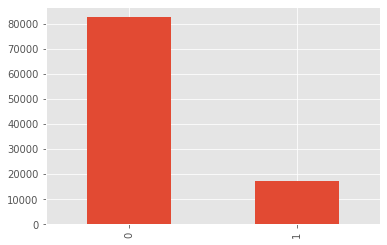

In [10]:
# data_df['click'].value_counts().plot(kind='bar')
data_df['click'].value_counts().plot(kind='bar')
# data_df['click'].value_counts().plot(kind='barh')

plt.show()

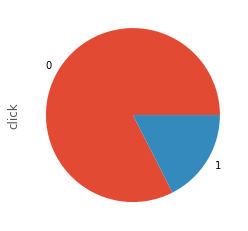

In [11]:
data_df['click'].value_counts().plot(kind='pie')
plt.show()

问题4（TODO）: 通过可视化方式来展示每一个位置上的样本总数以及其中被点击和没有被点击的样本个数。需要得到如下的这样的一幅图：

In [13]:
# banner_pos vs click
data_df['banner_pos'].value_counts()

0    80248
1    19714
2       21
5       10
4        6
Name: banner_pos, dtype: int64

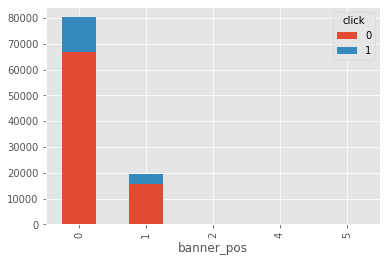

In [14]:
pd.crosstab(data_df['banner_pos'], data_df['click']).plot(kind = 'bar', stacked = True)
plt.show()

问题5（TODO)： 生成完上面的图之后能感觉到这个特征还是蛮重要的，而且由于banner_pos=2,4,5,7的样本比较少，在图里不那么直观。所以我们就尝试打印一下一个表格。表格里的每一行针对于的是banner_pos具体的值，另外表格有两列，分别是false和true, 分别代表在某一个banner_pos的样本，有百分之多少的概率不被点击和被点击。 生成出来的表格如下图所示：

In [15]:
table = pd.crosstab(data_df['banner_pos'],data_df['click'])
table.div(table.sum(1),axis = 0)

click,0,1
banner_pos,,
0,0.830538,0.169462
1,0.803033,0.196967
2,0.857143,0.142857
4,0.833333,0.166667
5,0.600000,0.400000


问题6（TODO）:这里重点研究一下，app_category特征，看是否跟标签有比较强的关系。 为了理解这一点，对于每一种类型的app_category值，请画出histogram，展示每一种取值条件下样本被点击或者没有被点击的概率。效果图如下：

In [20]:
data_df['app_category'].value_counts()

07d7df22    78827
0f2161f8    14971
f95efa07     2895
8ded1f7a     1347
cef3e649     1309
75d80bbe      171
4ce2e9fc      130
d1327cf5      129
09481d60       50
fc6fa53d       41
dc97ec06       40
a3c42688       32
0f9a328c       18
879c24eb       16
a86a3e89        8
7113d72a        7
a7fd01ec        4
8df2e842        2
4681bb9d        2
Name: app_category, dtype: int64

In [21]:
len(data_df['app_category'].unique())

19

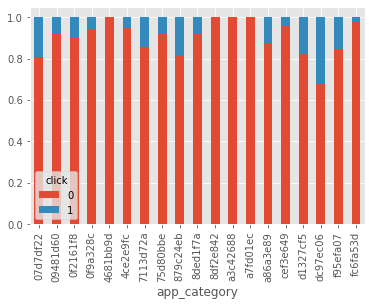

In [22]:
# TODO: 画出如上这幅图。
fig = pd.crosstab(data_df['app_category'], data_df['click'])
fig.div(fig.sum(1),axis=0).plot(kind = 'bar', stacked = True)
plt.show()

问题7(TODO): 对于不同的device_conn_type, 画一个histogram，并表示在不同type的情况下被点击和没有被点击的概率。效果图跟上面的问题（问题6）类似。

In [23]:
device_features = ['device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type']
data_df[device_features].astype('object').describe()

,device_id,device_ip,device_model,device_type,device_conn_type
count,99999,99999,99999,99999,99999
unique,7201,40376,2473,4,4
top,a99f214a,6b9769f2,8a4875bd,1,0
freq,86935,838,6886,92597,90707


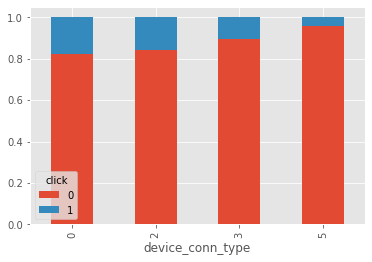

In [24]:
fig = pd.crosstab(data_df['device_conn_type'], data_df['click'])
fig.div(fig.sum(1),axis=0).plot(kind = 'bar', stacked = True)
plt.show()

问题8（TODO）： 请画出C1和点击率之间的关系。请参考问题6的样例图。

In [25]:
c_features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
data_df[c_features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,99999,99999,99999,99999,99999,99999,99999,99999,99999
unique,6,420,5,6,128,4,37,137,29
top,1005,20596,320,50,1722,0,35,-1,79
freq,92454,6809,95132,95620,38456,69496,55796,62161,38456


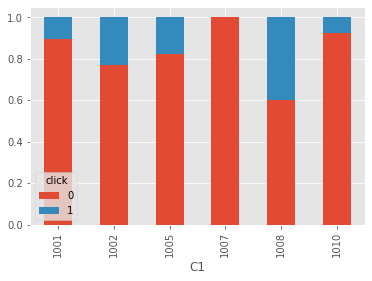

In [26]:
fig = pd.crosstab(data_df['C1'], data_df['click'])
fig.div(fig.sum(1),axis=0).plot(kind = 'bar', stacked = True)
plt.show()

问题9（TODO）: 把hour这个字段转换成离散型变量，分别是0，1，2。 也就是2014-10-21 00点对应到0， 2014-10-21 01点对应到1， 2014-10-21 02点对应到2. 并把原来的hour字段替换一下。

In [27]:
data_df['hour'] = data_df['hour'].astype('category').cat.codes
data_df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,0,0,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


问题10（TODO） 数据中的每一个特征，其实都可以看作是类别型特征（离散型）， 所以我们接下来要对所有的特征做独热编码的转换。这个时候总特征的维度就 变成每一个特征独热编码长度之和。 （也就是表格里的unique的之和）。务必要删除原始特征，因为已经把它们转换成了新的独热编码的形式。

In [29]:
# 由于这两个特征的稀疏性，从特征库中去掉。 但如果计算资源允许，可以加入进来。 
data_df.drop('device_id', axis=1, inplace=True)
data_df.drop('device_ip', axis=1, inplace=True)
data_df.drop('device_model', axis=1, inplace=True)
data_df.drop('site_id', axis=1, inplace=True)
data_df.drop('site_domain', axis=1, inplace=True)
data_df.drop('app_id', axis=1, inplace=True)


In [30]:
col = data_df.columns[data_df.columns != 'click']
data_df = pd.get_dummies(data_df, columns = col)

In [31]:
data_df.head()

,click,hour_0,C1_1001,C1_1002,C1_1005,C1_1007,C1_1008,C1_1010,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_4,banner_pos_5,site_category_0569f928,site_category_110ab22d,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_42a36e14,site_category_50e219e0,site_category_72722551,site_category_75fa27f6,site_category_76b2941d,site_category_a818d37a,site_category_bcf865d9,site_category_c0dd3be3,site_category_e787de0e,site_category_f028772b,site_category_f66779e6,app_domain_0654b444,app_domain_15ec7f39,app_domain_18eb4e75,app_domain_1ea19ec4,app_domain_1ed56ded,app_domain_2022d54e,app_domain_2347f47a,app_domain_27ee373d,app_domain_2b627705,app_domain_2d332391,app_domain_33da2e74,app_domain_3feeed1e,app_domain_43cf4f06,app_domain_45a51db4,app_domain_51174fb1,app_domain_56eabb45,app_domain_5ac0b939,app_domain_5b3f66ff,app_domain_5b9c592b,app_domain_5c5a694b,app_domain_5c620f04,...,C20_100193,C20_100194,C20_100195,C20_100199,C20_100200,C20_100202,C20_100205,C20_100206,C20_100210,C20_100212,C20_100213,C20_100215,C20_100217,C20_100221,C20_100224,C20_100225,C20_100228,C20_100229,C20_100233,C20_100241,C20_100248,C21_13,C21_15,C21_16,C21_20,C21_23,C21_32,C21_33,C21_42,C21_46,C21_48,C21_52,C21_61,C21_68,C21_70,C21_71,C21_79,C21_82,C21_85,C21_91,C21_93,C21_94,C21_95,C21_100,C21_101,C21_111,C21_116,C21_117,C21_156,C21_157
0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


问题11（TODO）： 使用基于L1的方法，请参考https://scikit-learn.org/stable/modules/feature_selection.html （SelectFromModel部分）。 我们使用的模型是逻辑回归 + L1的正则。 我们都知道L1正则会产生稀疏解，相当于帮我们选出特征。具体的方法是： 对于每一种可能的C值（代表正则的强弱)做交叉验证，从中选择效果最好的C值， 而且对于这个C值，我们有对应的选出来的特征。



In [32]:
# 构造训练数据和测试数据
feature_names = np.array(data_df.columns[data_df.columns != 'click'].tolist())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df[feature_names].values, # X
    data_df['click'].values,# y
    test_size=0.2,
    random_state=42
)

In [33]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(79999, 876) (20000, 876) (79999,) (20000,)


In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# TODO: 循环每一个C值，计算交叉验证后的F1-SCORE， 最终选择最好的C值c_best， 然后选出针对这个c_best对应的特征。 务必要使用L1正则。
#       对于实现，有很多方法，自行选择合理的方法就可以了。 关键是包括以下模块：1. 逻辑回归   2. 交叉验证  3. L1正则  4. SelectFromModel
kfold = KFold(n_splits = 5)
lr = LogisticRegression(penalty='l1', solver='liblinear')

params_c = np.logspace(-4, 1, 11)
model = GridSearchCV(lr,{"C":params_c},n_jobs = -1, cv = kfold,)
model.fit(X_train, y_train)
    
# 求出c_best
c_best = model.best_params_['C']

In [35]:
# 通过c_best值，重新在整个X_train里做训练，并选出特征。
lr_clf = LogisticRegression(penalty='l1', C=c_best)
lr_clf.fit(X_train, y_train) # 在整个训练数据重新训练

select_model = SelectFromModel(lr_clf, prefit=True)
selected_features = select_model.get_support()  # 被选出来的特征

# 重新构造feature_names
feature_names = feature_names[selected_features]

# 重新构造训练数据和测试数据
X_train = X_train[:, selected_features]
X_test = X_test[:, selected_features]

问题12（TODO）在我们选择特征的时候其实也用了逻辑回归，但要记住，选特征的时候用的是L1的正则。但是在真正来训练最终版本模型的时候我们通常都是使用L2正则。所以这里就按照这个逻辑来训练一个逻辑回归模型。需要注意的一点是：评价标准使用F1-SCORE, 包括在交叉验证阶段。

In [36]:
from sklearn.metrics import classification_report  #  这个用来打印最终的结果，包括F1-SCORE

params_c = np.logspace(-5,2,15) # 也可以自行定义一个范围

# TODO: 实现逻辑回归 + L2正则， 利用GrisSearchCV
lr = LogisticRegression(penalty = 'l2',solver = 'liblinear')
model = GridSearchCV(lr,{"C":params_c},scoring = 'f1',n_jobs=-1,cv=5)
model.fit(X_train,y_train)
# 输出最好的参数 
print(model.best_params_)


{'C': 100.0}


In [37]:
# TODO: 在测试数据上预测，并打印在测试集上的结果
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.84      0.98      0.90     16445
           1       0.52      0.11      0.18      3555

    accuracy                           0.82     20000
   macro avg       0.68      0.54      0.54     20000
weighted avg       0.78      0.82      0.77     20000



问题13（TODO）：在这里，我们使用决策树算法做分类。这部分内容还没有讲到，但没关系，在这里只是用来调用。在PART3里会涉及到决策树的细节。 决策树本身有很多超参数需要调节，所以调节决策树的复杂度要远高于逻辑回归模型。决策树的使用请参考: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html



In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

params_min_sampes_split = np.linspace(5, 20, 4, dtype=np.int)
params_min_samples_leaf = np.linspace(2, 10, 5, dtype=np.int)
params_max_depth = np.linspace(4, 10, 4, dtype=np.int)

# TODO: 构造决策树，并做交叉验证。 除了上面三个参数，其他参数用默认的。 
params = {"min_samples_split":params_min_sampes_split, "min_samples_leaf":params_min_samples_leaf, "max_depth":params_max_depth}
model = GridSearchCV(DecisionTreeClassifier(), params, scoring='f1', n_jobs=-1, cv=5 )
model.fit(X_train, y_train)


# 输出最好的参数 
print(model.best_params_)


{'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 5}


In [39]:
# TODO: 在测试数据上预测，并打印在测试集上的结果
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90     16445
           1       0.56      0.07      0.13      3555

    accuracy                           0.83     20000
   macro avg       0.70      0.53      0.52     20000
weighted avg       0.78      0.83      0.77     20000



## 利用启发式算法来调节参数 选做

In [43]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
 
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours
 
def lr_cv(C, data, targets):
    """lr cross validation.
    This function will instantiate a lr classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C that maximizes the roc_auc
    metric.
    """
    estimator = LogisticRegression(C=C, random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()
 

 
 
def optimize_lr(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""
 
    def lr_crossval(expC):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10 ** expC
        return lr_cv(C=C,data=data, targets=targets)
 
    optimizer = BayesianOptimization(
        f=lr_crossval,
        pbounds={"expC": (-3, 2)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)
 
    print("Final result:", optimizer.max)
 
 
if __name__ == "__main__": 
    print(Colours.yellow("--- Optimizing LR ---"))
    optimize_lr(X_train, y_train)
 

--- Optimizing LR ---
|   iter    |  target   |   expC    |
-------------------------------------
|  1        |  0.6983   | -2.042    |
|  2        |  0.7063   |  0.1105   |
|  3        |  0.7058   | -0.8114   |
|  4        |  0.7059   |  0.9268   |
|  5        |  0.7059   |  0.8999   |
|  6        |  0.7058   |  2.0      |
|  7        |  0.7061   |  0.5655   |
|  8        |  0.7058   |  2.0      |
|  9        |  0.706    |  0.6516   |
|  10       |  0.7061   |  0.656    |
|  11       |  0.706    |  0.6663   |
|  12       |  0.7058   |  2.0      |
|  13       |  0.7062   |  0.311    |
|  14       |  0.706    |  0.8616   |
|  15       |  0.7063   |  0.03179  |
Final result: {'target': 0.7062715990931798, 'params': {'expC': 0.11054385519915932}}


## 使用XGBoost做分类（选做部分, 不计为分数)

In [46]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
import operator
import time

X =X_train
y =y_train
print(X.shape)

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import time

print("start：********************************")
start = time.time()

auc_list = []
pred_list = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # 参数设置
    params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.02, 'max_depth': 4, 'min_child_weight': 6,
              'colsample_bytree': 0.7, 'subsample': 0.7, 'silent': 1, 'eval_metric': ['auc']}
    # 数据结构
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtrain, 'train'), (dvali, 'valid')]  # 'valid-auc' will be used for early stopping
    # 模型train
    model = xgb.train(params, dtrain,
                      num_boost_round=2000,
                      evals=evallist,
                      early_stopping_rounds=100,
                      verbose_eval=100)
    # 预测验证
    pred = model.predict(dvali, ntree_limit=model.best_ntree_limit)
    # 评估
    auc = roc_auc_score(y_test, pred)
    print('...........................auc value:', auc)
    auc_list.append(auc)
print('......................validate result mean :', np.mean(auc_list))
end = time.time()
print("......................run with time: ", (end - start) / 60.0)
print("over:*********************************")

(79999, 345)
start：********************************
[0]	train-auc:0.652739	valid-auc:0.655179
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.701615	valid-auc:0.699947
[200]	train-auc:0.708681	valid-auc:0.707176
[300]	train-auc:0.71241	valid-auc:0.710001
[400]	train-auc:0.714395	valid-auc:0.711531
[500]	train-auc:0.715968	valid-auc:0.712666
[600]	train-auc:0.717604	valid-auc:0.713331
[700]	train-auc:0.719069	valid-auc:0.714473
[800]	train-auc:0.719763	valid-auc:0.715008
[900]	train-auc:0.720773	valid-auc:0.715397
[1000]	train-auc:0.721354	valid-auc:0.71551
[1100]	train-auc:0.722294	valid-auc:0.715892
[1200]	train-auc:0.722905	valid-auc:0.716148
[1300]	train-auc:0.723515	valid-auc:0.716283


KeyboardInterrupt: 

In [ ]:
#!/usr/bin/env python  
# -*- coding:utf-8 _*-  
""" 
@author:quincyqiang 
@license: Apache Licence 
@file: 16_optuna.py 
@time: 2019-11-03 22:10
@description:
"""
import plotly.offline as py
import optuna
from optuna import Trial
import lightgbm as lgb
from sklearn.metrics import *
from sklearn.model_selection import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

X = X_train
y = y_train
test_data = test[features].values
print(X.shape)


def fit_lgbm_with_pruning(trial, train, val, devices=(-1,), seed=1314, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'binary_logloss'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": trial.suggest_int('bagging_freq',2,10),
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth',2,10),
        'min_child_weight': trial.suggest_int('max_depth',2,10),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'binary_logloss', valid_name='valid_1')
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    print('best_score', model.best_score)
    log = {'train/binary_logloss': model.best_score['training']['binary_logloss'],
           'valid/binary_logloss': model.best_score['valid_1']['binary_logloss']}
    return model, y_pred_valid, log


def objective_with_prune(trial: Trial, fast_check=True):
    """This method is completely same with previous `objective` method except calling `fit_lgbm_with_pruning`"""
    folds = 5
    seed = 666
    shuffle = False
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = X, y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()

    models0 = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train[train_idx, :], y_train[train_idx]
        valid_data = X_train[valid_idx, :], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data,
                                                         valid_data,
                                                         num_rounds=1000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models0.append(model)
        gc.collect()
        valid_score += log["valid/binary_logloss"]
        if fast_check:
            break
    valid_score /= len(models0)
    return valid_score

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective_with_prune, n_trials=50)
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))
# trials_df = study.trials_dataframe()
# print(trials_df)

optuna.visualization.plot_optimization_history(study)
plt.show()
optuna.visualization.plot_intermediate_values(study)
plt.show()
optuna.visualization.plot_slice(study)
plt.show()
optuna.visualization.plot_contour(study)
plt.show()
optuna.visualization.plot_parallel_coordinate(study)
plt.show()

# fig = optuna.visualization._get_intermediate_plot(study)
# py.plot(fig, filename='intermediate_values.html')
# fig.show()
#
#
# fig = optuna.visualization._get_slice_plot(study)
# py.plot(fig, filename='slice.html')
# fig.show()
#
# fig = optuna.visualization._get_contour_plot(study)
# py.plot(fig, filename='contour.html')
# fig.show()
#
# fig = optuna.visualization._get_parallel_coordinate_plot(study)
# py.plot(fig, filename='parallel_coordinate.html')
# fig.show()



def fit_lgbm(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'binary_logloss'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": trial.suggest_int('bagging_freq', 2, 10),
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_int('max_depth', 2, 10),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    print('best_score', model.best_score)
    log = {'train/binary_logloss': model.best_score['training']['binary_logloss'],
           'valid/binary_logloss': model.best_score['valid_1']['binary_logloss']}
    return model, y_pred_valid, log


def objective(trial: Trial, fast_check=True, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    # kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = X, y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train[train_idx, :], y_train[train_idx]
        valid_data = X_train[valid_idx, :], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data,
                                            num_rounds=1000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/binary_logloss"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score


def pred(X_test, models):
    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
        y_test_pred_total += y_pred_test
    y_test_pred_total /= len(models)
    return y_test_pred_total


valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()


def plot_feature_importance(model,features):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=features,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

y_test0 = pred(test_data, models0)
test['target']=y_test0
test[['id','target']].to_csv('result/optuna_submission.csv', index=False, float_format='%.7f')

plot_feature_importance(models0[1],features)
